In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.policies import policy_saver

2023-06-01 16:04:03.957571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-01 16:04:06.380355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:06.385976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:06.386228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 40,  # @param {type:"integer"}
"max_q_value" : 170, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 0,
"step_size" : 4,
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
session_name = 'rand_walk_interpol'
env = RLEnv(model_path=session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))


2023-06-01 16:04:11.935181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:11.935415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:11.935575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12

2023-06-01 16:04:16.972593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:16.972809: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-01 16:04:16.972926: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-01 16:04:16.973176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:16.973392: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-01 16:04:17.998187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:17.998456: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-01 16:04:17.999219: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-01 16:04:18.000000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:18.000194: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-01 16:04:21.587650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:21.587892: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-01 16:04:21.588201: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-01 16:04:21.589248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:21.589518: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-01 16:04:22.115817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:22.116050: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-01 16:04:22.116327: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-01 16:04:22.117198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-01 16:04:22.117397: I tensorflow/compiler/xla/stream_executor/

In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-01--16:04:23'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-06-01 16:04:24.633032: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-01 16:04:24.633183: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-01 16:04:31.913554: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 64.40000146627426
Average error 21.093331725844322


Timer unit: 0.001 s

Total time: 131.956 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 468

Line #      Hits         Time  Per Hit   % Time  Line Contents
   468                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   469        52          0.8      0.0      0.0  		city_ob = self.building_grid
   470        52          1.1      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   471        52          1.0      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   472                                           
   473                                           		# Get measured coords
   474        52          6.8      0.1      0.0  		measured_coords = self.get_measured_coords()
   475                                           
   476                                           		# UAV location grid
   477        52          1.4      0.0      0.0  		uav_location_grid

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-01 16:06:36.231435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-01 16:06:36.934533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors)

In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=1)

print((rand_reward, rand_pred_error))


(49.900005, 19.16757276620219)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,     
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp76mth2t_.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmp76mth2t_
[reverb/cc/platform/default/server.cc:71] Started replay server on port 38503


In [17]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())




Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([[[0.41822132, 0.18836324, 0.        ],
         [0.63555324, 0.18595457, 0.        ],
         [0.59936625, 0.20037478, 0.        ],
         ...,
         [0.60525286, 0.17701764, 0.        ],
         [0.5568843 , 0.21639349, 0.        ],
         [0.45571223, 0.23064788, 0.        ]],
 
        [[0.349076  , 0.1855028 , 0.        ],
         [0.29788452, 0.23029889, 0.        ],
         [0.34465152, 0.20757088, 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.15255246, 0.19609356, 0.        ],
         [0.12384963, 0.2337263 , 0.        ],
         [0.21607046, 0.23797905, 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.51990795,

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
env._reset()
print("")

In [22]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [23]:
best_reward = np.inf
losses = []
collect_rewards = []

In [24]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [25]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(train_log_dir)

for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step.reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (536273) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (536273) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (536273) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (536273) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (536273) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (536273) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
2023-06-01 16:25:50.792497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum' with dtype int32
	 [[{{node critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/cond/zeros/packed/critic_loss/distribution_errors/distribution_errors/histogram/write_summary/buckets/Maximum}}]]
2023-06-01 16:25:50.799286: I tensorflow/core/common_runtime/executor.cc:1197] [/d

step = 0: loss = 4.248373508453369,  rew = 69.9999988079071


step = 0: Average Return = 79.4113540649414, Average Error = 19.71329466891056
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 1000: loss = 4.197297096252441,  rew = 81.19500875473022
step = 2000: loss = 4.185865879058838,  rew = 82.9300045967102
step = 3000: loss = 4.1815948486328125,  rew = 76.83000564575195
step = 4000: loss = 4.144648551940918,  rew = 73.87500405311584
step = 5000: loss = 4.148357391357422,  rew = 63.37500214576721
step = 6000: loss = 4.123719215393066,  rew = 80.36500215530396
step = 7000: loss = 4.099126815795898,  rew = 61.07500195503235
step = 8000: loss = 4.009254455566406,  rew = 68.65000128746033
step = 9000: loss = 4.062969207763672,  rew = 72.53999710083008
step = 10000: loss = 4.023929595947266,  rew = 79.30999994277954
step = 11000: loss = 4.045909881591797,  rew = 71.00500464439392
step = 12000: loss = 3.9085190296173096,  rew = 82.51000046730042
step = 13000: loss = 3.9468655586242676,  rew = 71.7699944972992
step = 14000: loss = 3.925537347793579,  rew = 79.56500053405762
step = 15000: loss = 3.858137607574463,  rew = 70.31499743461609
step = 16000: loss = 3.7838706970

step = 200000: Average Return = 79.13067626953125, Average Error = 19.5286041557923
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 201000: loss = 3.3709869384765625,  rew = 83.75999927520752
step = 202000: loss = 3.2979588508605957,  rew = 73.20500612258911
step = 203000: loss = 3.1730995178222656,  rew = 78.08499932289124
step = 204000: loss = 3.386669874191284,  rew = 82.35499858856201
step = 205000: loss = 3.3095929622650146,  rew = 85.91999411582947
step = 206000: loss = 3.227673053741455,  rew = 80.2150011062622
step = 207000: loss = 3.3814539909362793,  rew = 80.77499866485596
step = 208000: loss = 3.2978553771972656,  rew = 74.80999827384949
step = 209000: loss = 3.230639934539795,  rew = 70.7349956035614
step = 210000: loss = 3.451742172241211,  rew = 73.92999529838562
step = 211000: loss = 3.4271085262298584,  rew = 77.91000008583069
step = 212000: loss = 3.546834945678711,  rew = 72.10000157356262
step = 213000: loss = 3.4229955673217773,  rew = 68.99000406265259
step = 214000: loss = 3.383366823196411,  rew = 71.62500023841858
step = 215000: loss = 3.370854139328003,  rew = 65.3149962425232
step 

step = 550000: Average Return = 79.78899383544922, Average Error = 19.231752998807448
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 551000: loss = 3.234494686126709,  rew = 76.54500007629395
step = 552000: loss = 3.4218177795410156,  rew = 78.67500185966492
step = 553000: loss = 3.314833164215088,  rew = 75.49499869346619
step = 554000: loss = 3.3547821044921875,  rew = 88.4399950504303
step = 555000: loss = 3.3659887313842773,  rew = 79.44999933242798
step = 556000: loss = 3.422626256942749,  rew = 83.21500420570374
step = 557000: loss = 3.3347089290618896,  rew = 86.52999997138977
step = 558000: loss = 3.386134147644043,  rew = 83.43999981880188
step = 559000: loss = 3.4249720573425293,  rew = 55.32500743865967
step = 560000: loss = 3.4090123176574707,  rew = 68.00999641418457
step = 561000: loss = 3.486158847808838,  rew = 75.3849983215332
step = 562000: loss = 3.4851794242858887,  rew = 87.1500015258789
step = 563000: loss = 3.459540367126465,  rew = 73.38999509811401
step = 564000: loss = 3.4557464122772217,  rew = 71.1899995803833
step = 565000: loss = 3.2374515533447266,  rew = 82.61500000953674
step 

step = 650000: Average Return = 79.78266906738281, Average Error = 19.19406457409963
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 651000: loss = 3.41056752204895,  rew = 79.26999926567078
step = 652000: loss = 3.509286880493164,  rew = 65.83499908447266
step = 653000: loss = 3.486522674560547,  rew = 67.1549916267395
step = 654000: loss = 3.4560563564300537,  rew = 73.64000082015991
step = 655000: loss = 3.38308048248291,  rew = 79.89000082015991
step = 656000: loss = 3.3319873809814453,  rew = 84.61500406265259
step = 657000: loss = 3.4700255393981934,  rew = 64.30000066757202
step = 658000: loss = 3.3194711208343506,  rew = 73.04499745368958
step = 659000: loss = 3.330228805541992,  rew = 66.00000262260437
step = 660000: loss = 3.308689594268799,  rew = 83.32999348640442
step = 661000: loss = 3.397726058959961,  rew = 74.29500222206116
step = 662000: loss = 3.3991198539733887,  rew = 81.04499578475952
step = 663000: loss = 3.3922083377838135,  rew = 72.5600004196167
step = 664000: loss = 3.4982850551605225,  rew = 87.13000416755676
step = 665000: loss = 3.45713472366333,  rew = 72.65499830245972
step = 6

step = 1050000: Average Return = 80.3010025024414, Average Error = 18.800614265169994
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 1051000: loss = 3.3600878715515137,  rew = 78.8800060749054
step = 1052000: loss = 3.57607102394104,  rew = 78.33000421524048
step = 1053000: loss = 3.4251065254211426,  rew = 89.85999822616577
step = 1054000: loss = 3.3033463954925537,  rew = 56.7050039768219
step = 1055000: loss = 3.4033312797546387,  rew = 85.19499897956848
step = 1056000: loss = 3.555309772491455,  rew = 74.04000163078308
step = 1057000: loss = 3.5126779079437256,  rew = 81.33999705314636
step = 1058000: loss = 3.6153740882873535,  rew = 68.82500052452087
step = 1059000: loss = 3.4729015827178955,  rew = 82.79500007629395
step = 1060000: loss = 3.502607583999634,  rew = 77.39999890327454
step = 1061000: loss = 3.541569232940674,  rew = 79.86999750137329
step = 1062000: loss = 3.4721739292144775,  rew = 85.24500131607056
step = 1063000: loss = 3.515502452850342,  rew = 80.18000721931458
step = 1064000: loss = 3.5162205696105957,  rew = 74.45499897003174
step = 1065000: loss = 3.5748937129974365,  rew = 64.034

step = 1400000: Average Return = 82.13066101074219, Average Error = 18.669131977644085
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 1401000: loss = 3.611492156982422,  rew = 75.07500052452087
step = 1402000: loss = 3.6523475646972656,  rew = 57.92999863624573
step = 1403000: loss = 3.557574510574341,  rew = 69.80500221252441
step = 1404000: loss = 3.5497853755950928,  rew = 88.3650004863739
step = 1405000: loss = 3.682312488555908,  rew = 85.85000038146973
step = 1406000: loss = 3.6432974338531494,  rew = 78.74000072479248
step = 1407000: loss = 3.597594738006592,  rew = 79.4700026512146
step = 1408000: loss = 3.6077871322631836,  rew = 70.33500075340271
step = 1409000: loss = 3.6265318393707275,  rew = 72.6449966430664
step = 1410000: loss = 3.5778284072875977,  rew = 85.03999710083008
step = 1411000: loss = 3.7721469402313232,  rew = 83.74999761581421
step = 1412000: loss = 3.637880325317383,  rew = 77.7649998664856
step = 1413000: loss = 3.5362792015075684,  rew = 68.52499842643738
step = 1414000: loss = 3.57470440864563,  rew = 73.7749993801117
step = 1415000: loss = 3.663464307785034,  rew = 62.94499635

step = 2000000: Average Return = 80.38065338134766, Average Error = 18.64093393496737
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-01--16:04:23/assets


step = 2001000: loss = 3.6313390731811523,  rew = 85.45999526977539
step = 2002000: loss = 3.699298858642578,  rew = 84.46500301361084
step = 2003000: loss = 3.61431622505188,  rew = 84.38000679016113


In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

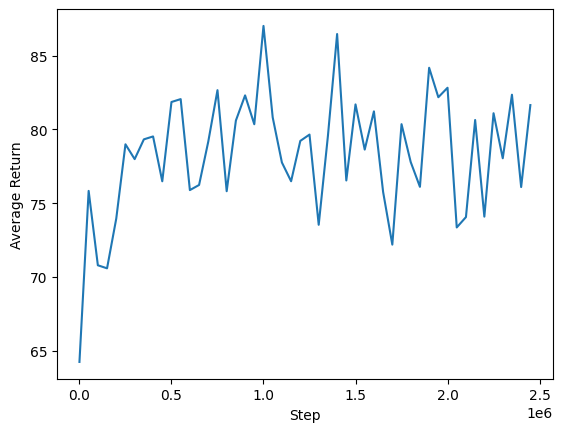

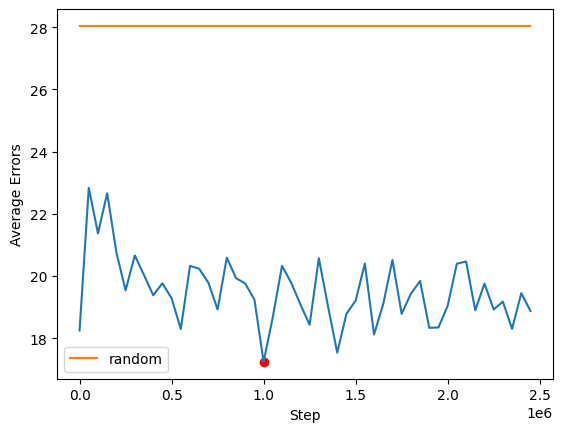

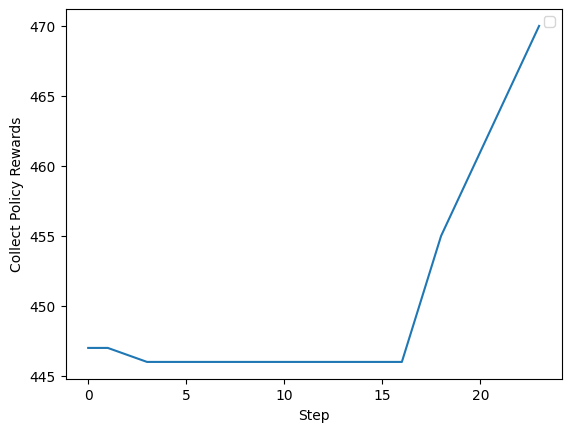

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

80.19085 18.635467358914795


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

78.338776 19.694380071568798


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, saved_policy, 500)
print(avg_return, avg_error)

79.48077 19.297141854548613
